In [1]:
# 自作モジュールの参照先を上書き
import sys
parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride


import time
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

from module.lino_module.preprocess import mode_of_freq, tde_dataset_wm,\
                                          select_device
from module.lino_module.model import TransformerModel, training, learning_plot,\
                                     confirmation, to_time_series,\
                                     confirmation_plot

# 乱数固定
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データセットの準備

In [2]:
data = pd.read_csv('../data/sales_train.csv')
data = mode_of_freq(data).item_cnt_day
seq = 7
d_model = 64
dilation = 2
src_tgt_seq = (int(seq * 0.9),int(seq * 0.4))

kwrgs = {'data': data,
         'seq': seq,
         'd_model': d_model,
         'dilation': dilation,
         'src_tgt_seq': src_tgt_seq,
         'weekly': True,
         'monthly': True,
         'batch_size': 64}

train, test = tde_dataset_wm(**kwrgs)

## Transformerモデルの準備

In [3]:
# device = select_device() # mps では Transformer の attention でエラーが出る
device = torch.device('cpu')

if kwrgs['weekly'] & kwrgs['monthly']:
    dim = d_model * 3
elif kwrgs['weekly'] | kwrgs['monthly']:
    dim = d_model * 2
else:
    dim = d_model

transformer = TransformerModel(d_model=dim, nhead=8).to(device)
# criterion = RMSELoss()  # 論文ではRMSELoss
criterion = nn.MSELoss()

# 学習率その他は論文の値を参考
step_num = 1
warmup_steps = 5000
lr = d_model**0.5 * min(step_num**0.5, step_num * warmup_steps**(-1.5))
optimizer = Adam(transformer.parameters(), lr=1e-5, betas=(0.95, 0.98), eps=10e-9)

## 訓練

In [4]:
epochs = 100
training_kwrgs = {'model': transformer,
                  'dataset': train,
                  'device': device,
                  'criterion': criterion,
                  'optimizer': optimizer,
                  'epochs': epochs,
                  'verbose': 10,
                  'center': 50}
transformer, train_loss, validation_loss = training(**training_kwrgs)

--------------------- start ----------------------
                     epoch_0                      
train_loss:  1.1683 | validation_loss:  1.0961 | time:  3.265
                     epoch_10                     
train_loss:  0.4815 | validation_loss:  0.3901 | time:  3.042
                     epoch_20                     
train_loss:  0.3538 | validation_loss:  0.2587 | time:  3.094
                     epoch_30                     
train_loss:  0.273 | validation_loss:  0.1986 | time:  3.035
                     epoch_40                     
train_loss:  0.2194 | validation_loss:  0.1632 | time:  3.435
                     epoch_50                     
train_loss:  0.1987 | validation_loss:  0.1344 | time:  3.345
                     epoch_60                     
train_loss:  0.167 | validation_loss:  0.1187 | time:  3.209
                     epoch_70                     
train_loss:  0.1503 | validation_loss:  0.1084 | time:  3.164
                     epoch_80                  

## 訓練データ損失と検証データ損失

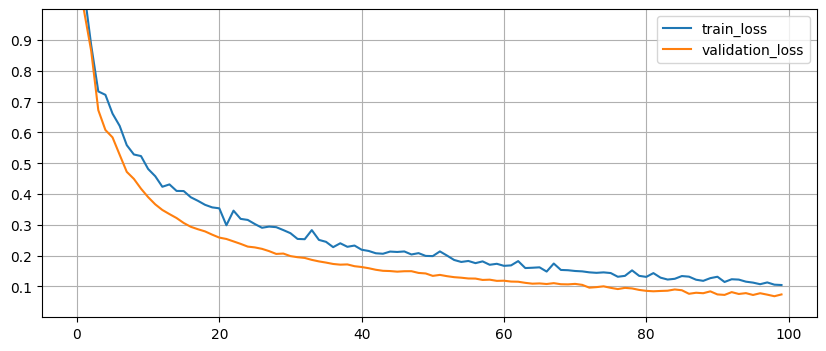

In [5]:
# ファイル名の作成
name = ''
for key, value in kwrgs.items():
    if key=='data':
        pass
    else:
        name += f'{key}({value})_'

img_path = '../Lino_notebook/img_wm/'
figsize = (10, 4)
saving = True
learning_plot(train_loss, validation_loss, img_path, name, figsize, saving)

### 訓練データとテストデータで予測

### 予測データのプロット

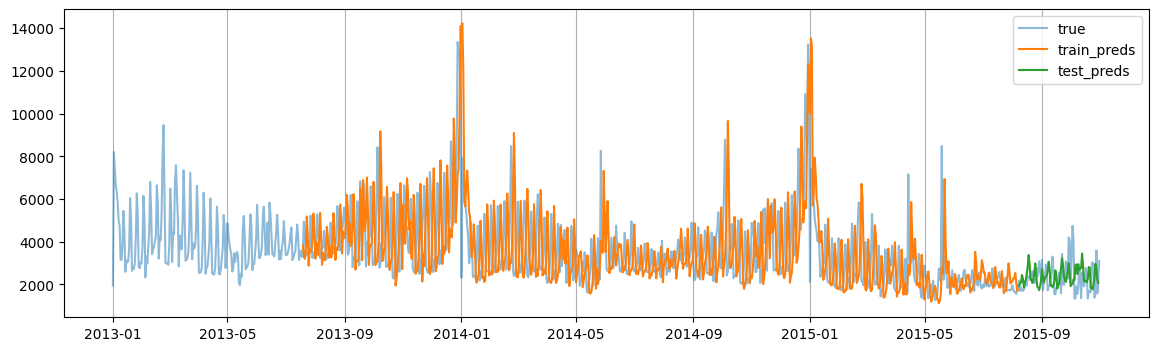

In [6]:
figsize = (14, 4)
train_preds, test_preds = confirmation(transformer, train, test)
train_time_series, test_time_series, original = to_time_series(data, train_preds, test_preds, StandardScaler, d_model, dilation, seq)
confirmation_plot(train_time_series, test_time_series, original, img_path, name, figsize, saving)

## モデルの保存

In [7]:
kwrgs['model'] = transformer
model_dir = './models_wm/'
model_name = name + '.pkl'
with open(model_dir + model_name, 'wb') as f:
    pickle.dump(kwrgs, f)